Install libs

In [1]:
!pip install opendatasets -q
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

Import libs

In [2]:
import tensorflow as tf
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

Download cats and dogs dataset from kaggle

In [3]:
od.download("https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nipunweerasinghe99
Your Kaggle Key: ··········


100%|██████████| 217M/217M [00:04<00:00, 53.0MB/s]


Seperate batches and set image size

In [4]:
BATCH_SIZE = 32   #
IMAGE_SIZE = (128,128)    #   Input image shape

Set data for train and test

In [5]:
train_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/test"

Split training into train data(0.9) and validation data(0.1) |
Set test data

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    subset='training',
    validation_split=0.1,
    seed=42
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    subset='validation',
    validation_split=0.1,
    seed=42
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [7]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [8]:
for image_batch,label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 128, 128, 3)
(32,)


Plot random images from the dataset

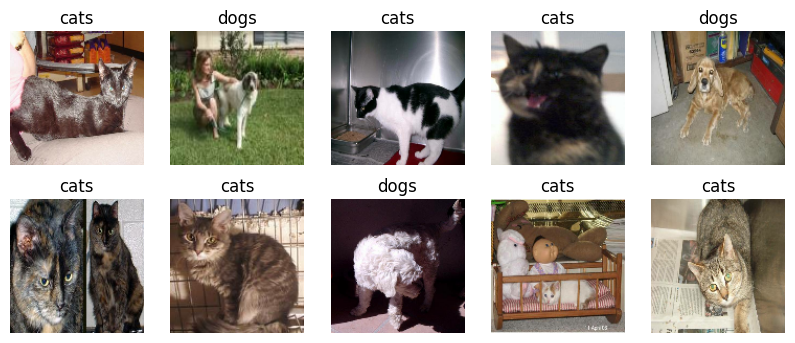

In [9]:
# Plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.axis('off')

In [10]:
for image,label in train_data.take(1):
  for i in range(1):
    print(image)

tf.Tensor(
[[[[101.00769   104.00769   109.00769  ]
   [111.074585  112.71521   114.30505  ]
   [117.635284  115.31354   112.59396  ]
   ...
   [129.86246   132.91324   136.22964  ]
   [126.8725    133.10297   135.69281  ]
   [128.9002    138.99207   139.94614  ]]

  [[ 85.20029    88.20029    93.20029  ]
   [ 99.3725     99.79227   101.78906  ]
   [114.00287   112.997925  110.048706 ]
   ...
   [116.720825  120.720825  123.720825 ]
   [119.9389    126.16937   128.75922  ]
   [138.79547   147.0824    148.93893  ]]

  [[ 92.54297    94.90234    99.58203  ]
   [ 91.57605    91.986206   93.986206 ]
   [105.38388   104.38388   101.75107  ]
   ...
   [120.73743   125.52237   128.52237  ]
   [130.21445   135.21445   138.21445  ]
   [127.32648   134.36554   136.68585  ]]

  ...

  [[118.07504   122.07504   125.07504  ]
   [121.617584  125.617584  128.61758  ]
   [130.54602   134.54602   137.54602  ]
   ...
   [ 81.51825    87.02301    96.76108  ]
   [ 45.951294   50.819916   54.147003 ]
   [ 

In [11]:
# Normalize
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

Data augmentation

In [12]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

Model buliding

In [13]:
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128,kernel_size=3,activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(32,activation='relu'))

model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

Model architecture

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)      

Compile the model

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

Train the model under 30 epochs. You can adjust it. Take some time, So better to run with T4 (in Colab) or under high performance

In [16]:
start_time = time.time()

history=model.fit(
    train_data,
    epochs=30,
    validation_data=validation_data
)

end_time = time.time()

Epoch 1/30
225/225 [==============================] - 18s 40ms/step - loss: 0.6812 - accuracy: 0.5710 - val_loss: 0.6726 - val_accuracy: 0.5650
Epoch 2/30
225/225 [==============================] - 9s 40ms/step - loss: 0.6413 - accuracy: 0.6276 - val_loss: 0.6478 - val_accuracy: 0.6587
Epoch 3/30
225/225 [==============================] - 10s 43ms/step - loss: 0.6335 - accuracy: 0.6315 - val_loss: 0.6679 - val_accuracy: 0.5850
Epoch 4/30
225/225 [==============================] - 10s 45ms/step - loss: 0.6179 - accuracy: 0.6561 - val_loss: 0.6582 - val_accuracy: 0.6050
Epoch 5/30
225/225 [==============================] - 8s 36ms/step - loss: 0.6064 - accuracy: 0.6686 - val_loss: 0.6185 - val_accuracy: 0.6700
Epoch 6/30
225/225 [==============================] - 9s 39ms/step - loss: 0.5821 - accuracy: 0.6899 - val_loss: 0.5761 - val_accuracy: 0.7200
Epoch 7/30
225/225 [==============================] - 10s 43ms/step - loss: 0.5539 - accuracy: 0.7150 - val_loss: 0.5947 - val_accuracy: 0.

Plot the Accuracy

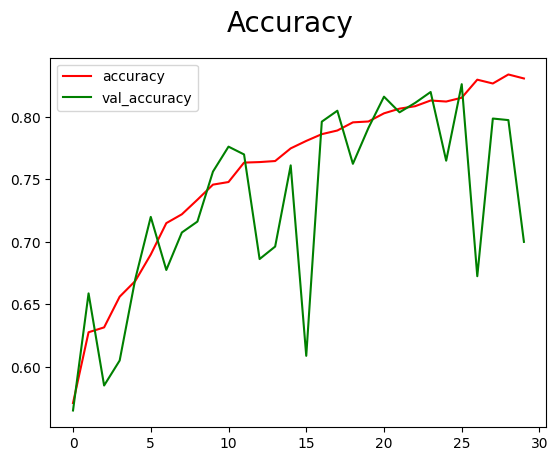

In [17]:
fig = plt.figure()
plt.plot(history.history['accuracy'],color="red",label='accuracy')
plt.plot(history.history['val_accuracy'],color="green",label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend()
plt.show()

Plot losses

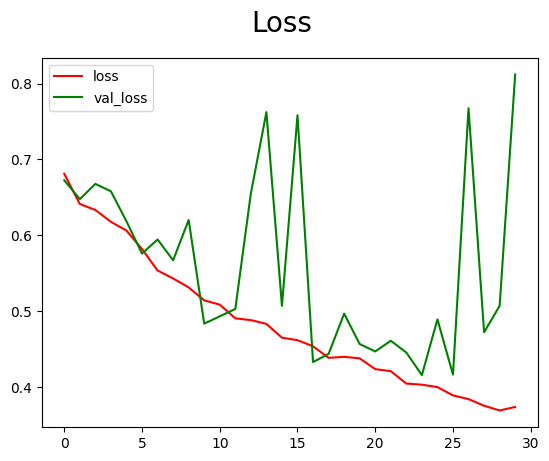

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'],color="red",label='loss')
plt.plot(history.history['val_loss'],color="green",label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend()
plt.show()

In [19]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

Model already trained. Now lets see how to use this model.

In [ ]:
# !pip install opencv-python

In [24]:
import cv2 #import this for read images

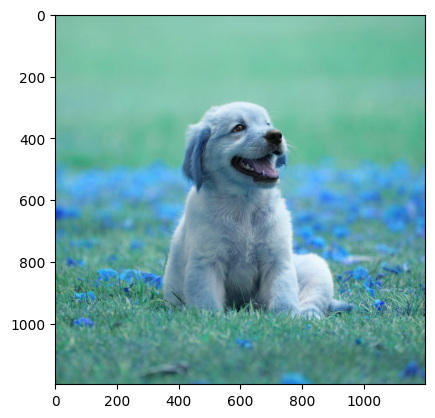

In [ ]:
img = cv2.imread('image path')
plt.imshow(img)
plt.show()

IMAGE_SIZE = (128,128) | We created the Input layer with 128 neurons.
Every pixel devide by 255 for better normalization

In [ ]:
resize = tf.image.resize(img,IMAGE_SIZE)
scaled = resize/255

In [ ]:
# Need to change shape of "scaled"
np.expand_dims(scaled,0).shape

(1, 128, 128, 3)

In [ ]:
img_new = np.expand_dims(scaled,0)

After setting up above cmnd, This is way how to call model

In [ ]:
y_hat = model.predict(img_new)

If y_hat >= 0.5, its a dog. O/w a cat. class_names = [cats,dogs] # Check in top lines

In [ ]:
if y_hat>=0.5:
  print(f"{y_hat} : {class_names[1]}")
else:
  print(f"{y_hat} : {class_names[0]}")

[[0.85683036]] : dogs
